# FEEDFORWARD NEURAL NETWORK (MLP) MODEL BUILD

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Train and Test Datasets

In [5]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight


# Set dataset directory path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/"

# Load preprocessed train and test sets
train_df = pd.read_csv(dataset_path + "train.csv")
test_df = pd.read_csv(dataset_path + "test.csv")

print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

Train dataset shape: (1515164, 16)
Test dataset shape: (726426, 16)


## Separate Features and Labels

In [8]:
# Identify feature columns (all except label columns)
label_column = 'Label'
feature_columns = [col for col in train_df.columns if col != label_column]

# Extract features (X) and labels (y)
X_train, y_train = train_df[feature_columns], train_df[label_column]
X_test, y_test = test_df[feature_columns], test_df[label_column]

# Encode labels into integer categories
y_train, label_encoder = pd.factorize(y_train)
y_test = label_encoder.get_indexer(y_test)

print(f"Feature columns: {len(feature_columns)}, Label classes: {len(label_encoder)}")
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
print("Number of Feature used:", len(feature_columns))

Feature columns: 15, Label classes: 13
Training samples: 1515164, Testing samples: 726426
Number of Feature used: 15


# Define and Train the MLP Model

In [9]:
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

start = time.time()

MLP = MLPClassifier(
    random_state=1,
    max_iter=300
)
MLP.fit(X_train, y_train)

end = time.time()
print(f'Elapsed Training Time: {(end - start)/60:.2f} minutes')

Elapsed Training Time: 35.82 minutes


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


# Performance Predictions





In [10]:
tart = time.time()
y_pred = MLP.predict(X_test)
y_pred_proba = MLP.predict_proba(X_test)  # Needed for AUC-ROC Score
end = time.time()

print(f'Elapsed Prediction Time: {(end - start)/60:.2f} minutes')

Elapsed Prediction Time: 73.48 minutes


# Generate Confusion Matrix

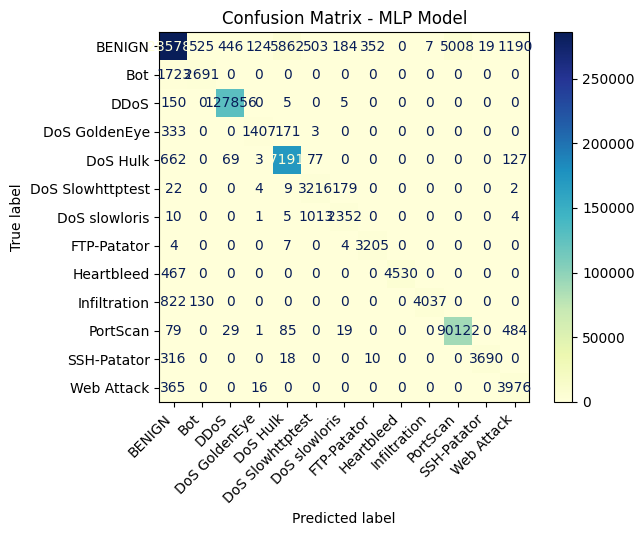


Classification Report:
                  precision    recall  f1-score   support

          BENIGN       0.98      0.95      0.97    300000
             Bot       0.80      0.61      0.69      4414
            DDoS       1.00      1.00      1.00    128016
   DoS GoldenEye       0.90      0.74      0.81      1914
        DoS Hulk       0.97      0.99      0.98    172849
DoS Slowhttptest       0.67      0.94      0.78      3432
   DoS slowloris       0.86      0.69      0.77      3385
     FTP-Patator       0.90      1.00      0.94      3220
      Heartbleed       1.00      0.91      0.95      4997
    Infiltration       1.00      0.81      0.89      4989
        PortScan       0.95      0.99      0.97     90819
     SSH-Patator       0.99      0.91      0.95      4034
      Web Attack       0.69      0.91      0.78      4357

        accuracy                           0.97    726426
       macro avg       0.90      0.88      0.88    726426
    weighted avg       0.97      0.97      0.9

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate Classification Report
# ✅ Load the saved LabelEncoder
encoder_path = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/label_encoder.pkl"
label_encoder = joblib.load(encoder_path)

# ✅ Convert class labels to strings
class_names = [str(cls) for cls in label_encoder.classes_]

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='YlGnBu', values_format='d')

plt.title('Confusion Matrix - MLP Model')
plt.xticks(rotation=45, ha="right")
plt.show()


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Compute Performance Metrics

In [16]:
def ACC(TP, TN, FP, FN):
    return (TP + TN) / (TP + FP + FN + TN)

def PRECISION(TP, FP):
    return TP / (TP + FP)

def RECALL(TP, FN):
    return TP / (TP + FN)

def F1(Recall, Precision):
    return 2 * Recall * Precision / (Recall + Precision)

def BACC(TP, TN, FP, FN):
    return (TP / (TP + FN) + TN / (TN + FP)) * 0.5

def MCC(TP, TN, FP, FN):

    TP, TN, FP, FN = map(np.float64, [TP, TN, FP, FN])

    numerator = (TN * TP - FN * FP)
    denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    if denominator == 0:
        return 0

    return np.clip(numerator / denominator, -1, 1)

TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

# Compute Metrics
Acc = ACC(sum(TP), sum(TN), sum(FP), sum(FN))
Precision = PRECISION(sum(TP), sum(FP))
Recall = RECALL(sum(TP), sum(FN))
F1_score = F1(Recall, Precision)
BACC_score = BACC(sum(TP), sum(TN), sum(FP), sum(FN))
MCC_score = MCC(sum(TP), sum(TN), sum(FP), sum(FN))

# Print Performance Metrics
print(f'Accuracy: {Acc:.4f}')
print(f'Precision: {Precision:.4f}')
print(f'Recall: {Recall:.4f}')
print(f'F1 Score: {F1_score:.4f}')
print(f'BACC: {BACC_score:.4f}')
print(f'MCC: {MCC_score:.4f}')

Accuracy: 0.9954
Precision: 0.9702
Recall: 0.9702
F1 Score: 0.9702
BACC: 0.9839
MCC: 0.9677


# Compute AUC-ROC Score

In [19]:
n_classes = len(label_encoder.classes_)
y_test_binarized = label_binarize(y_test, classes=range(n_classes))
auc_score = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovr")

print(f"AUC-ROC Score: {auc_score:.4f}")

AUC-ROC Score: 0.9982


# Save the Trained MLP Model

In [21]:
# Save the trained model
model_folder = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/"
model_filename = "CICIDS-2017_MLP.joblib"
model_path = model_folder + model_filename
joblib.dump(MLP, model_path)

print(f"🚀 **Feedforward Neural Network model saved to:** {model_path}")

🚀 **Feedforward Neural Network model saved to:** /content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/CICIDS-2017_MLP.joblib
